<a href="https://colab.research.google.com/github/cs-pub-ro/ML/blob/master/homework/2020-2021/hw1/Tema_1_Skel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tema 1 - A taste for music
## Găsirea genului pentru piese

### Autori: 
* George Muraru
* Alexandru Sorici

## 1. Scopul temei



Tema are ca scop folosirea metodelor de clasificare studiate în cadrul cursului/laboratorului pentru a **determina genul muzical** al unor sample-uri audio dintr-un set de date.

Se dorește înțelegerea procedurii tipice de **prelucrare a unui set de date**, de **explorare a atributelor**, precum și efectuarea unei **analize comparative** a mai multor algoritmi de clasificare, evidențiând diferențele între ei prin metrici precum *acuratețe, precizie, regăsire (eng. recall)*. 

## 2. Set de date

Primul pas în orice problema de data science este încărcarea și "înțelegerea" datelor.

Setul de date utilizat poartă denumirea de Free Music Archive [[1]](#fma). 

Dataset-ul utilizat este "usor" modificat - va conține doar 4 genuri muzicale: *Rock*, *Hip-Hop*, *Folk* și *Electronic*.

Setul de date este deja echilibrat (eng. balanced) -- sunt câte 500 de piese din fiecare gen în setul de train și câte 100 în cel de testare.

Dacă setați parametrul [DOWNLOAD_SAMPLE_DATASET](#scrollTo=te02bqsfMhls) se va descărca și un audio sample pentru fiecare track_id atunci când se rulează celula specifică pentru secțiunea [Descărcare](#scrollTo=RxCYjmzTM82o).

Puteți asculta sample-ul din piesă [aici](#scrollTo=te02bqsfMhls).

Se va folosi drept **clasă** (eticheta care trebuie prezisa) *genul muzical cel mai general* (numele coloanei în engleza este *top_genre*) pentru fiecare piesă.


Setul de date conține pentru fiecare sample mai multe atribute (eng. features), de tip numeric, care pot fi folosite pentru clasificare. Acestea pot fi găsite în fișierele *features.csv* sau *echonest.csv*.


Pentru mai multe informații privind setul de date, se poate consulta [acest repository](https://github.com/mdeff/fma).

Dataset-ul utilizat este o copie ușor modificată a celor [3 dataset-uri](https://github.com/mdeff/fma#Data): *fma_small.zip*, *fma_medium.zip*, *fma_large.zip*.

## 3. Workspace Setup

### Parametrii

In [1]:
# Music samples -- has ~ 2GB
DOWNLOAD_SAMPLE_DATASET = True  #@param {type: "boolean"}

### Dependențe

In [2]:
!pip install pandas # needed for loading the dataset
!pip install xgboost

if DOWNLOAD_SAMPLE_DATASET:
    !pip install ffmpeg # Needed by librosa for mp3
    !pip install librosa
    !pip install tqdm # Progress bar for dowloading large file

### Import biblioteci

In [3]:
if DOWNLOAD_SAMPLE_DATASET:
    from tqdm import tqdm
    import librosa

import pandas as pd
from zipfile import ZipFile

import IPython.display as ipd

### Funcții ajutătoare

In [4]:
def _reporthook(t):
    """ ``reporthook`` to use with ``urllib.request`` that prints the process of the download.

    Uses ``tqdm`` for progress bar.

    **Reference:**
    https://github.com/tqdm/tqdm

    Args:
        t (tqdm.tqdm) Progress bar.
    """
    last_b = [0]

    def inner(b=1, bsize=1, tsize=None):
        """
        Args:
            b (int, optional): Number of blocks just transferred [default: 1].
            bsize (int, optional): Size of each block (in tqdm units) [default: 1].
            tsize (int, optional): Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return inner

def getHomeworkArchives():
    """ Checks if the homework dataset is present in the local directory, if not,
    downloads it.
    """
    from os import path

    dataset_info = {
        "fma_song_info.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_info.zip",
        "fma_song_samples.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_samples.zip" # Need to upload this
    }

    for dataset_file, dataset_url in dataset_info.items():
        if not path.isfile(dataset_file):
            import urllib
            with tqdm(unit='B', unit_scale=True, miniters=1, desc=dataset_file) as t:
                urllib.request.urlretrieve(dataset_url, filename=dataset_file, reporthook=_reporthook(t))

            assert(path.isfile(dataset_file))

            with ZipFile(dataset_file, 'r') as zip_ref:
                zip_ref.extractall()
        else:
            print(f"{dataset_file} already in the local directory")


# ALL THE FUCTIONS FROM THIS POINT FORWARD ARE NEEDED ONLY IF
# DOWNLOAD_SAMPLE_DATASET IS TRUE
def load_tracks():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/tracks.csv"), index_col=0, header=[0,1])


def load_features():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open('song_info/features.csv'), index_col=0, header=[0,1,2])


def load_echonest():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/echonest.csv"), index_col=0, header=[0,1,2])


def get_song_path(track_id: int):
    ''' Given a track id return the path to the sample

    Args:
        track_id (int): the id for a song found the dataset

    Returns:
        The path to the sample relative to the current directory
    '''

    return f'song_samples/{track_id:06}.mp3'

### Descărcare

In [5]:
getHomeworkArchives()

fma_song_info.zip already in the local directory
fma_song_samples.zip already in the local directory


### Încărcare date

In [6]:
# Load Echonest features for our dataset
echonest = load_echonest()
tracks = load_tracks()
features = load_features()

# True/False masks for selecting training/test
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'].isin(['test', 'validation'])

# Get X and Y
X_train = echonest.loc[train, ('echonest', 'audio_features')]
X_test = echonest.loc[test, ('echonest', 'audio_features')]

Y_train = tracks.loc[train, ('track', 'genre_top')]
Y_test = tracks.loc[test, ('track', 'genre_top')]

## 4. Problemă de rezolvat



Împărțim problema de rezolvat a acestei teme în două subpuncte principale:
  * Implementarea unui clasificator al genului muzical (eng. genre) pentru un anumit sample de piesă prin intermediul a patru algoritmi (KMeans, Decision Trees/Random Forest, XGBoost, SVM, Naive Bayes). Construirea unei variante de baza (eng. baseline) a clasificatorului pentru fiecare algoritm propus.
  * Explorarea metodelor prin care pot fi îmbunătățite rezultatele fiecarui algoritm în parte (e.g. varierea atributelor, prelucrarea suplimentară a atributelor, modificarea hiperparametrilor algoritmului), evaluarea comparativă intra- (i.e. față de baseline pentru același tip de algoritm) și inter-algoritm.

### 4.1. Implementare si rulare clasificatori [6pct]

Pentru acest task se vor rula mai mulți algoritmi pe setul de date și vor fi notate rezultatele obținute.

Veți crea câte un clasificator folosind fiecare din cei patru algoritmi din următoarea listă:
  * KMeans [1 pct]
  * Arbori de decizie, păduri aleatoare [1 pct]
  * XGBoost [1 pct]
  * SVM [1 pct]
  * Naive Bayes [1 pct]

**Observație 1:** Pentru KMeans, fiind **nesupervizat**, vom presupune că *nu* se știe că numărul de clustere este 4.

**Observație 2:** Algoritmii listați **nu** trebuie implementati de mana (nu obligatoriu). Este permisă utilizarea versiunilor din biblioteci cunoscute (a se vedea exemplele sugerate mai jos).


#### **Utilizarea setului de date**
În general, majoritatea seturilor de date sunt împărțite în:
* setul de antrenare (eng. training dataset) - se rulează algoritmul de învățare pe acest set (eng. fit the model)
* setul de validare (eng. validation dataset sau dev set) - se utilizează pentru modificarea hiperparametrilor algoritmului (eng. tunning the hyperparameters)
* setul de testare (eng. testing dataset sau holdout dataset) - se rulează pentru testarea finală a algoritmului.

În scheletul temei, testul de validare și de testare sunt concatenate.

#### **Implementare algoritmi**
Dezvoltați clasificatorii *baseline* pe baza fiecărui algoritm din cei listați mai sus. 
Utilizați implementările default din bibliotecile alese pentru a obține baseline-ul.
Folosiți drept features *audio_features* din tabela de *echonest* (sunt deja selectate în schelet).

Folosiți set-ul *train* pentru antrenare și *test* pentru testare.

#### **Evaluare** [1 pct]
Găsiți [aici](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) o listă cu metrici folosite, in general, pentru evaluarea algoritmilor de machine learning.

Pentru fiecare algoritm în parte, raportați **cel puțin** metricile de *accuracy*, *precision*, *recall*, *f-score* și *matricea de confuzie (eng. confusion matrix)*.

**Observații KMeans**
1. Având în vedere că KMeans nu este un algoritm supervizat, putem să combinăm cele 2 seturi de date (train + testare) pentru a face clusterizarea.
2. Faceți rescale *feature-urilor* astfel încât acestea să fie centrate în 0 cu o deviație standard de 1 - standardizarea datelor (vedeți Referințe).
3. Rulați KMeans pe setul de antrenare utilizând un număr diferit de clustere (eg. 2, 3, 4, 5, 6).
4. Verificați utlizând metoda [silhouette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) care este numărul optim de clustere (puteți încerca și cu [elbow](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml) însă va trebui să creșteți lungmea intervalului de clustere).
5. Alegeți numărul optim de clustere și calculați **doar** *randIndex*.
6. [Opțional] Puteți analiza coordonatele centroizilor pentru a observa cum diferă genurile muzicale în funcție de *audio_features*. 
6. [Opțional] Puteți testa să vedeți că piesele din același cluster seamănă utilizând codul de de la finalul notebook-ului.

**Observații DecisionTree/RandomForest**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) din biblioteca scikit-learn. 

**Observații XGBoost**

Implementarea sugerată este cea din biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

**Observații SVM**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/svm.html) din biblioteca scikit-learn.

**Observații Naive Bayes**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/naive_bayes.html) din bibilioteca scikit-learn.

In [7]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pandas import DataFrame, merge
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, f1_score,\
    make_scorer, normalized_mutual_info_score, rand_score, recall_score, precision_score,\
    silhouette_samples, silhouette_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import quantile_transform, StandardScaler
from sklearn.svm import SVC
from statistics import mean, stdev
from xgboost import XGBClassifier


ACC = RAND = 0
PREC = NMI = 1
REC = DUMMY = 2
F1 = 3
CONF = 4


X_train.append(X_test)
Y_train.append(Y_test)

X_temp = echonest.loc[train, ('echonest', 'temporal_features')].append(
    echonest.loc[test, ('echonest', 'temporal_features')]
)
X_imp = merge(X_train, X_temp, on='track_id')
X_imp = merge(X_imp, features, on='track_id')

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    Y_train,
    test_size=0.2,
    random_state=42
)

/home/teo/.local/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,3 on the right)
  warnings.warn(msg, UserWarning)


For n_clusters = 2 The average silhouette_score is : 0.1643131380878863
For n_clusters = 3 The average silhouette_score is : 0.17182269994972718
For n_clusters = 4 The average silhouette_score is : 0.18363789763136726
For n_clusters = 5 The average silhouette_score is : 0.17785620264703783
For n_clusters = 6 The average silhouette_score is : 0.1770846853891851


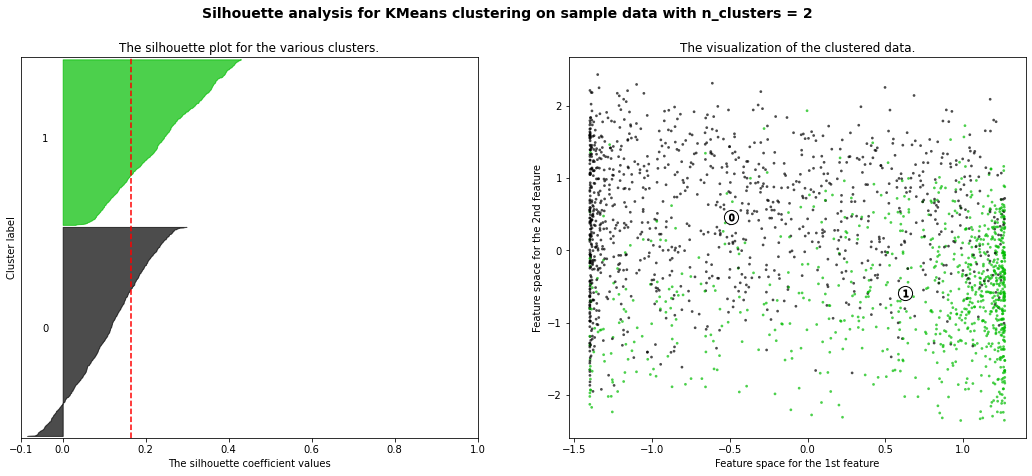

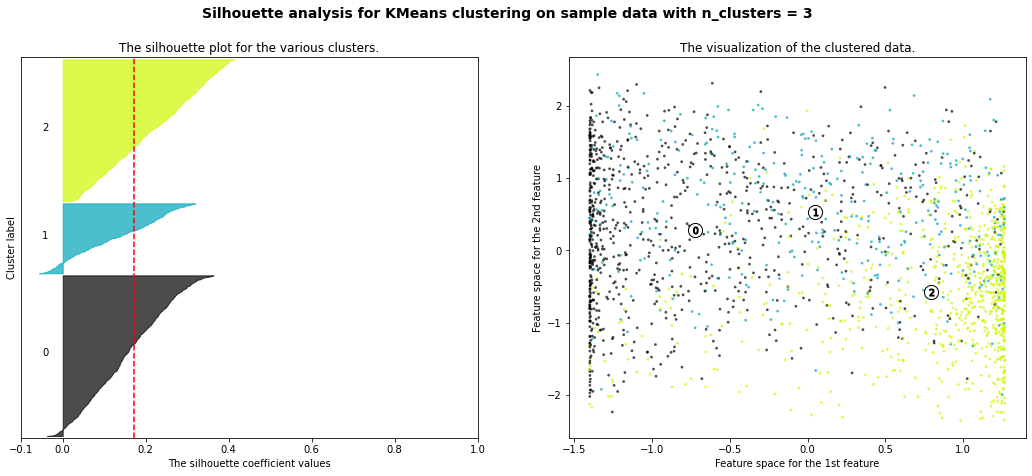

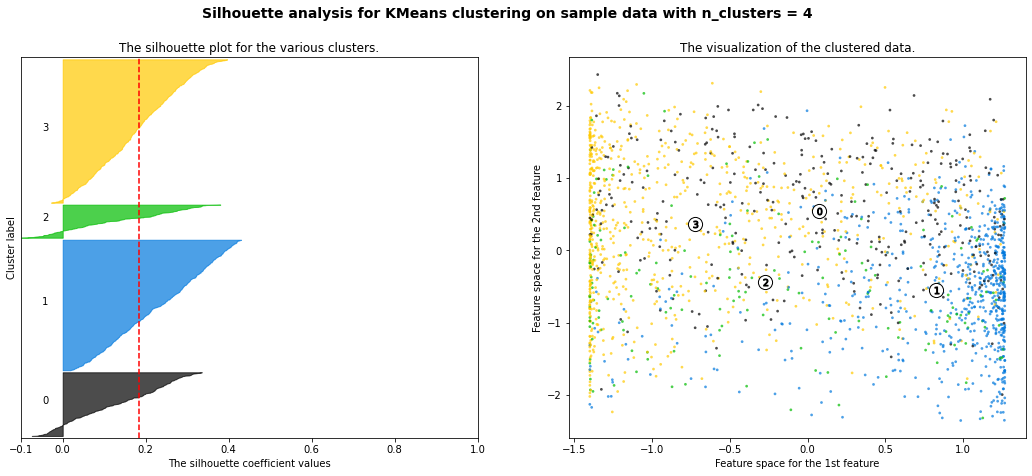

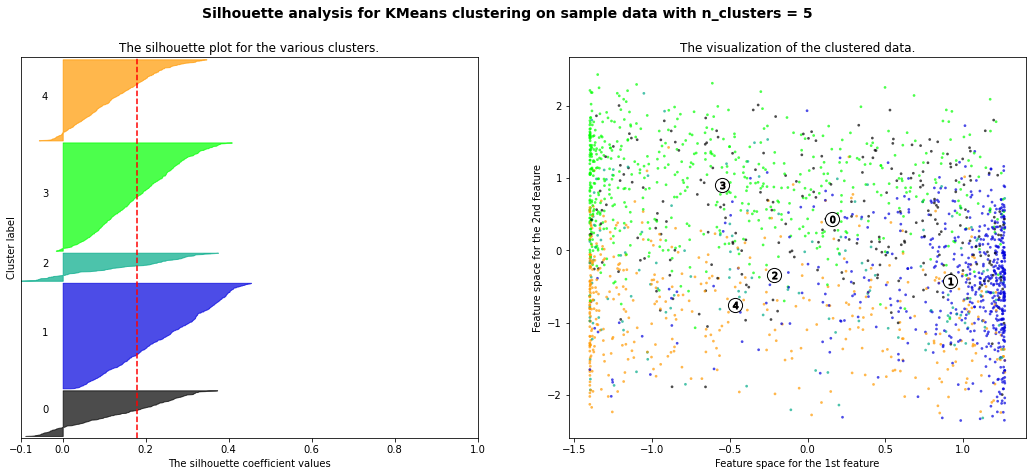

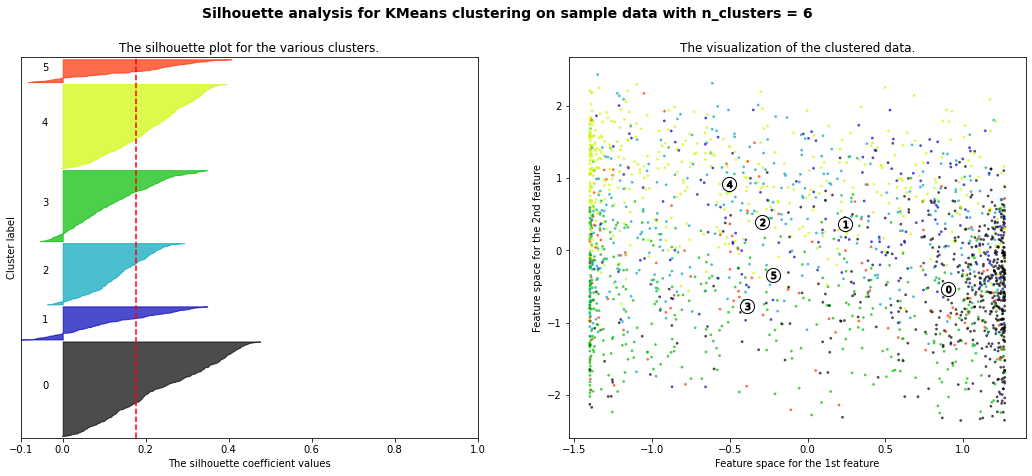

In [8]:
def scale_features(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)


def compute_sihlouette(X):
    '''
    https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    '''
    range_n_clusters = [2, 3, 4, 5, 6]
    scores = []

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
        print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

    plt.show()
    return scores.index(max(scores)) + 2


KMEANS_NUM_CLASSES = compute_sihlouette(scale_features(
    X_train.copy().append(X_test)
))

In [9]:
def tune_dataset(X, Y, n_features, scale=False):
    X_imp = DataFrame(SelectKBest(f_classif, k=n_features).fit_transform(X, Y))

    if scale:
        X_imp = quantile_transform(X_imp, output_distribution='uniform')

    return train_test_split(X_imp, Y, test_size=0.2, random_state=42)


X_TRAIN = 0
X_TEST = 1
Y_TRAIN = 2
Y_TEST = 3
AUG_SETS = {
    'Random Forest': tune_dataset(X_imp, Y_train, 'all', True),
    'XGBoost': tune_dataset(X_imp, Y_train, 'all', True),
    'SVC': tune_dataset(X_imp, Y_train, 'all', True),
    'Naive Bayes': tune_dataset(X_imp, Y_train, 'all', True),
    'KMeans': tune_dataset(X_imp, Y_train, 'all', True)
}
IMP_SETS = {
    'Random Forest': tune_dataset(X_imp, Y_train, 500, True),
    'XGBoost': tune_dataset(X_imp, Y_train, 500, True),
    'SVC': tune_dataset(X_imp, Y_train, 500, True),
    'Naive Bayes': tune_dataset(X_imp, Y_train, 500, True),
    'KMeans': tune_dataset(X_imp, Y_train, 100, True)
}

/home/teo/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [412 415 416 421] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/teo/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/teo/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [412 415 416 421] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/teo/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/teo/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [412 415 416 421] are constant.
  warnings.warn("Features %s are constant." % con

In [10]:
def _compute_scores(Y_test, Y_pred, **kwargs):
    alg = kwargs['alg']
    scores = kwargs['scores']

    if alg != 'KMeans':
        acc = accuracy_score(Y_test, Y_pred)
        prec = precision_score(Y_test, Y_pred, average='weighted')
        rec = recall_score(Y_test, Y_pred, average='weighted')
        f1 = f1_score(Y_test, Y_pred, average='weighted')
        conf = confusion_matrix(Y_test, Y_pred)

        if alg in scores:
            scores[alg][ACC].append(acc)
            scores[alg][PREC].append(prec)
            scores[alg][REC].append(rec)
            scores[alg][F1].append(f1)
            scores[alg][CONF].append(conf)
        else:
            scores[alg] = [[acc], [prec], [rec], [f1], [conf]]
    else:
        rand = rand_score(Y_test, Y_pred)
        nmi = normalized_mutual_info_score(Y_test, Y_pred)

        if alg in scores:
            scores[alg][RAND].append(rand)
            scores[alg][NMI].append(nmi)
            scores[alg][DUMMY].append(0)
        else:
            scores[alg] = [[rand], [nmi], [0]]

    return 0

In [11]:
BASE_MODELS = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'SVC': SVC(),
    'Naive Bayes': ComplementNB(),
    'KMeans': KMeans(n_clusters=KMEANS_NUM_CLASSES)
}
SCORES_BASE = {}


for alg, model in BASE_MODELS.items():
    cross_val_score(
        model,
        X_train,
        y_train,
        scoring=make_scorer(_compute_scores, alg=alg, scores=SCORES_BASE)
    )

for classif in SCORES_BASE:
    for i in range(len(SCORES_BASE[classif]) - 1):
        SCORES_BASE[classif][i] = {
            'mean': mean(SCORES_BASE[classif][i]),
            'stddev': stdev(SCORES_BASE[classif][i])
        }

/home/teo/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[20:40:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/home/teo/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

In [12]:
IMP_MODELS = {
    'Random Forest': RandomForestClassifier(n_jobs=12, n_estimators=250, max_features='log2', max_samples=0.9, criterion='gini'),
    'XGBoost': XGBClassifier(alpha=0.1, min_child_weight=0.7, eta=0.5),
    'SVC': SVC(kernel='poly', degree=4),
    'Naive Bayes': ComplementNB(),
    'KMeans': KMeans(n_clusters=KMEANS_NUM_CLASSES)
}
SCORES_IMP = {}


for alg, model in IMP_MODELS.items():
    cross_val_score(
        model,
        IMP_SETS[alg][X_TRAIN],
        IMP_SETS[alg][Y_TRAIN],
        scoring=make_scorer(_compute_scores, alg=alg, scores=SCORES_IMP)
    )

for classif in SCORES_IMP:
    for i in range(len(SCORES_IMP[classif]) - 1):
        SCORES_IMP[classif][i] = {
            'mean': mean(SCORES_IMP[classif][i]),
            'stddev': stdev(SCORES_IMP[classif][i])
        }

/home/teo/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[20:40:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/home/teo/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier 

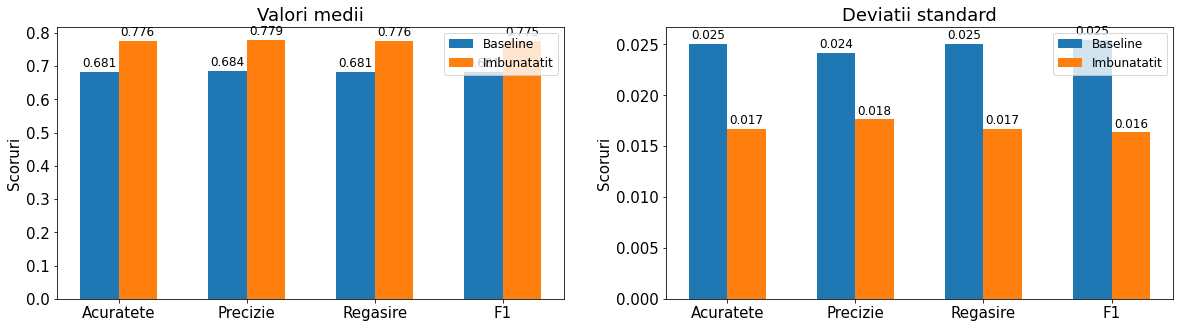

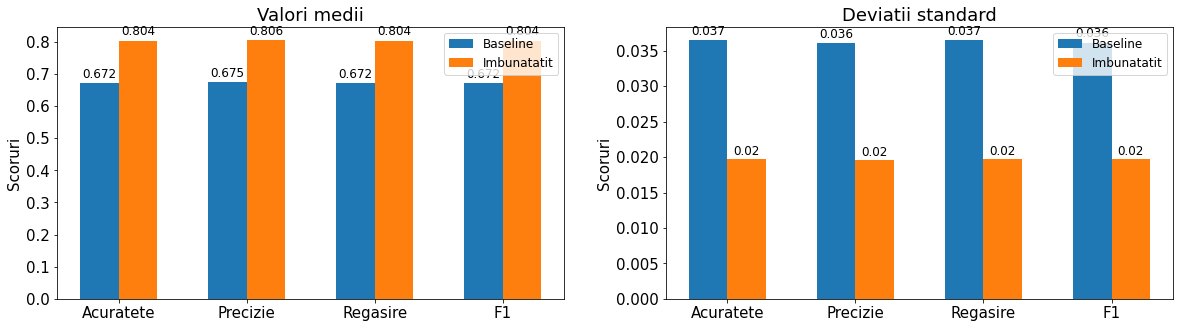

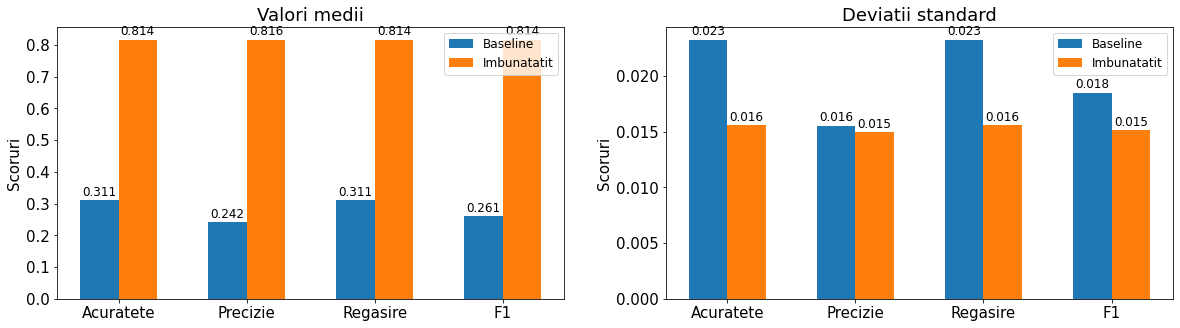

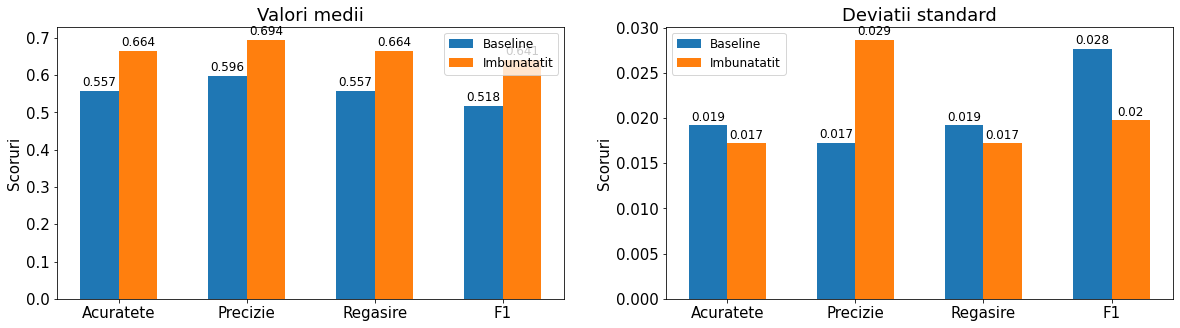

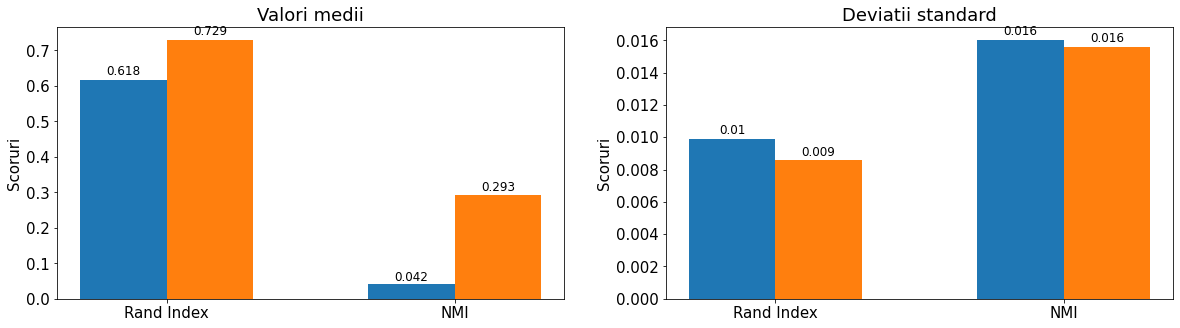

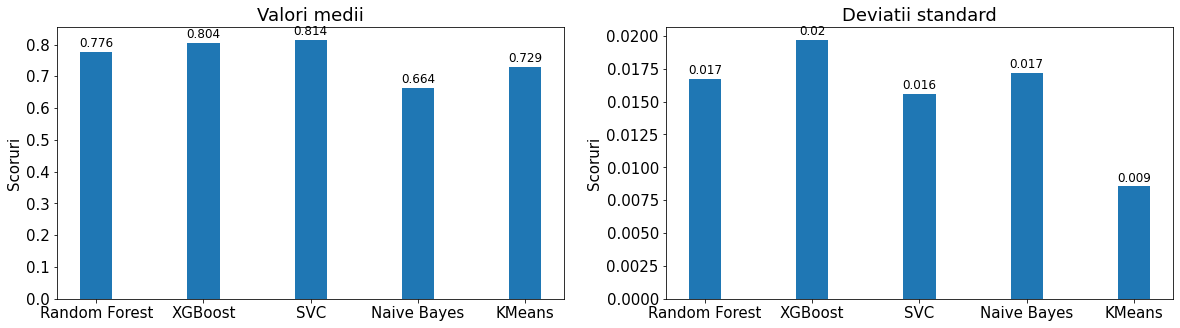

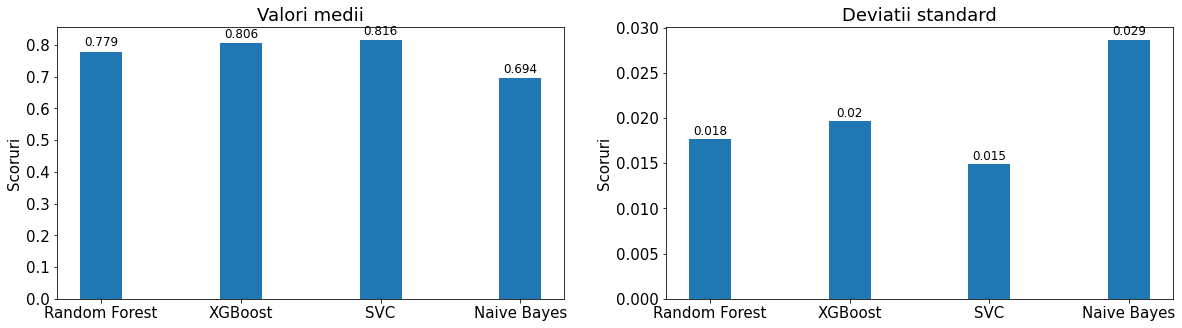

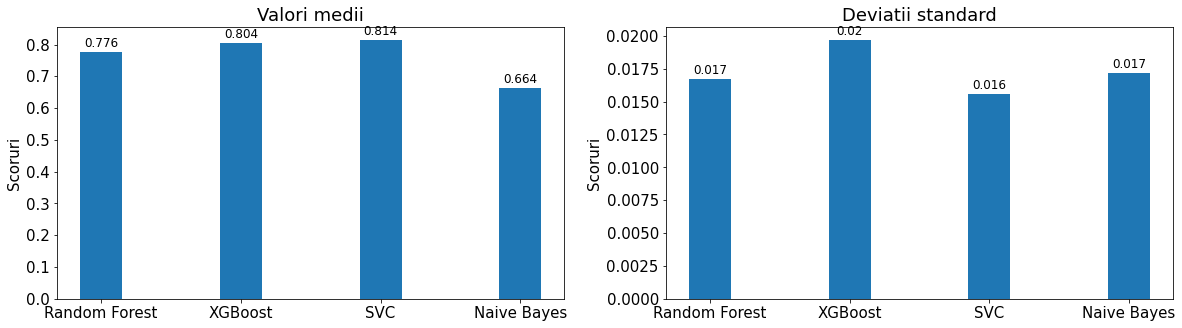

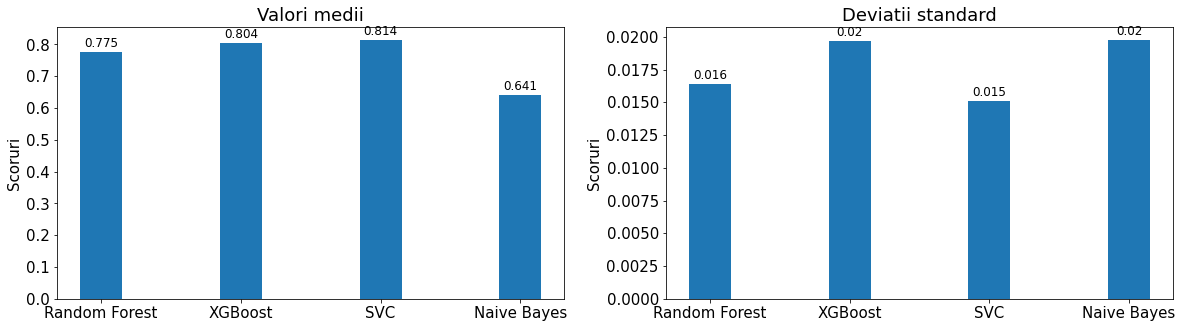

In [13]:
CLASSIFIERS = ['Random Forest', 'XGBoost', 'SVC', 'Naive Bayes', 'KMeans']
METRICS = ['Acuratete', 'Precizie', 'Regasire', 'F1']
width = 0.3


def _set_plt_properties(ax, x, labels):
    ax[0].set_title('Valori medii', fontsize=18)
    ax[0].set_ylabel('Scoruri', fontsize=15)
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(labels, fontsize=15)
    ax[1].set_title('Deviatii standard', fontsize=18)
    ax[1].set_ylabel('Scoruri', fontsize=15)
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(labels, fontsize=15)
    if (labels == METRICS):
        ax[0].legend(fontsize=12)
        ax[1].legend(fontsize=12)

    for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()\
            + ax[1].get_xticklabels() + ax[1].get_yticklabels()):
	    label.set_fontsize(15)


def _label(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.,
            height * 1.01,
            round(height, 3),
            fontsize = 12,
            ha='center',
            va='bottom'
        )


x = np.arange(len(METRICS))
for classif in CLASSIFIERS:
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    base_mean = [SCORES_BASE[classif][i]['mean']
        for i in range(len(SCORES_BASE[classif]) - 1)]
    imp_mean = [SCORES_IMP[classif][i]['mean']
        for i in range(len(SCORES_IMP[classif]) - 1)]
    base_std = [SCORES_BASE[classif][i]['stddev']
        for i in range(len(SCORES_BASE[classif]) - 1)]
    imp_std = [SCORES_IMP[classif][i]['stddev']
        for i in range(len(SCORES_IMP[classif]) - 1)]

    if classif == 'KMeans':
        x = x[:2]
        labels = ['Rand Index', 'NMI']
    else:
        labels = METRICS

    base_mean_rect = ax[0].bar(x - width/2, base_mean, width, label='Baseline')
    imp_mean_rect = ax[0].bar(x + width/2, imp_mean, width, label='Imbunatatit')
    _label(base_mean_rect, ax[0])
    _label(imp_mean_rect, ax[0])   

    base_std_rect = ax[1].bar(x - width/2, base_std, width, label='Baseline')
    imp_std_rect = ax[1].bar(x + width/2, imp_std, width, label='Imbunatatit')
    _label(base_std_rect, ax[1])
    _label(imp_std_rect, ax[1])   

    _set_plt_properties(ax, x, labels)

    plt.show()

for i, score in enumerate(METRICS):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    clasifiers = CLASSIFIERS if not i else CLASSIFIERS[:-1]
    x = np.arange(len(clasifiers))

    imp_mean = [SCORES_IMP[classif][i]['mean'] for classif in clasifiers]
    imp_std = [SCORES_IMP[classif][i]['stddev'] for classif in clasifiers]

    mean_rect = ax[0].bar(x, imp_mean, width)
    std_rect = ax[1].bar(x, imp_std, width)
    _label(mean_rect, ax[0])
    _label(std_rect, ax[1])

    _set_plt_properties(ax, x, clasifiers)

    plt.show()

In [14]:
def plot_stats_per_num_features(model, alg, path, nums_features, scale):
    acc = []
    prec = []
    rec = []
    f1 = []
    rand = []
    nmi = []

    x_train = AUG_SETS[alg][X_TRAIN]
    y_train = AUG_SETS[alg][Y_TRAIN]

    for n_features in nums_features:
        X, _, Y, _ = tune_dataset(x_train, y_train, n_features, scale)
        SCORES = {}

        cross_val_score(
            model, X,Y,
            scoring=make_scorer(_compute_scores, alg=alg, scores=SCORES)
        )

        if alg == 'KMeans':
            rand.append(mean(SCORES[alg][RAND]))
            nmi.append(mean(SCORES[alg][NMI]))
        else:
            acc.append(mean(SCORES[alg][ACC]))
            prec.append(mean(SCORES[alg][PREC]))
            rec.append(mean(SCORES[alg][REC]))
            f1.append(mean(SCORES[alg][F1]))
    
    plt.figure()
    if alg == 'KMeans':
        plt.plot(nums_features, rand, label='Rand Index')
        plt.plot(nums_features, nmi, label='NMI')
    else:
        plt.plot(nums_features, acc, label='Acuratete')
        plt.plot(nums_features, prec, label='Precizie')
        plt.plot(nums_features, rec, label='Regasire')
        plt.plot(nums_features, f1, label='F1')
    plt.legend()
    plt.ylabel('Scoruri', fontsize=15)
    plt.xlabel('Numar de caracteristici', fontsize=15)
    plt.savefig(path)


def plot_stats_per_params(name, alg, path, param_name, param_values):
    acc = []
    prec = []
    rec = []
    f1 = []
    rand = []
    nmi = []

    x_train = AUG_SETS[alg][X_TRAIN]
    y_train = AUG_SETS[alg][Y_TRAIN]

    for val in param_values:
        model = name.set_params(**{param_name: val})
        SCORES = {}

        cross_val_score(
            model,
            x_train,
            y_train,
            scoring=make_scorer(_compute_scores, alg=alg, scores=SCORES)
        )

        if alg == 'KMeans':
            rand.append(mean(SCORES[alg][RAND]))
            nmi.append(mean(SCORES[alg][NMI]))
        else:
            acc.append(mean(SCORES[alg][ACC]))
            prec.append(mean(SCORES[alg][PREC]))
            rec.append(mean(SCORES[alg][REC]))
            f1.append(mean(SCORES[alg][F1]))
    
    plt.figure()
    if alg == 'KMeans':
        plt.plot(param_values, rand, label='Rand Index')
        plt.plot(param_values, nmi, label='NMI')
    else:
        plt.plot(param_values, acc, label='Acuratete')
        plt.plot(param_values, prec, label='Precizie')
        plt.plot(param_values, rec, label='Regasire')
        plt.plot(param_values, f1, label='F1')
    plt.legend()
    plt.ylabel('Scoruri', fontsize=15)
    plt.xlabel(param_name, fontsize=15)
    plt.savefig(path)


# plot_stats_per_num_features(RandomForestClassifier(), 'Random Forest', 'images/graphs/rfc/features.png', range(1, X_imp.shape[1] + 1, 25), True)
# plot_stats_per_num_features(ComplementNB(), 'Naive Bayes', 'images/graphs/nb/features.png', range(1, X_imp.shape[1] + 1, 25), True)
# plot_stats_per_num_features(XGBClassifier(), 'XGBoost', 'images/graphs/xgb/features.png', range(1, X_imp.shape[1] + 1, 25), True)
# plot_stats_per_num_features(SVC(), 'SVC', 'images/graphs/svc/features.png', range(1, X_imp.shape[1] + 1, 25), True)
# plot_stats_per_num_features(SVC(kernel='linear'), 'SVC', range(1, IMP_SETS['SVC'][X_TRAIN].shape[1] + 1), True)
# plot_stats_per_num_features(KMeans(n_clusters=KMEANS_NUM_CLASSES), 'KMeans', 'images/graphs/km/featrues.png', range(1, IMP_SETS['KMeans'][X_TRAIN].shape[1] + 1, 10), True)

# plot_stats_per_params(RandomForestClassifier(), 'Random Forest', 'images/graphs/rfc/n_estimators.png', 'n_estimators', range(100, 651, 50))  # 250
# plot_stats_per_params(RandomForestClassifier(), 'Random Forest', 'images/graphs/rfc/max_features.png', 'max_features', ['sqrt', 'log2', *list(range(1, 9))])  # log2
# plot_stats_per_params(RandomForestClassifier(), 'Random Forest', 'images/graphs/rfc/criterion.png', 'criterion', ['gini', 'entropy'])  # gini
# plot_stats_per_params(RandomForestClassifier(), 'Random Forest', 'images/graphs/rfc/max_samples.png', 'max_samples', np.arange(0.01, 1.0, 0.01))  # 0.9

# # plot_stats_per_params(SVC(), 'SVC', 'images/graphs/svc/gamma.png', 'gamma', np.arange(0.1, 10, 0.1))  # valori mai mici
# # plot_stats_per_params(SVC(), 'SVC', 'images/graphs/svc/tol.png', 'tol', [10**-i for i in range(0, 10)])  # dubios. mai bine nu
# # plot_stats_per_params(SVC(), 'SVC', 'images/graphs/svc/decision_function_shape.png', 'decision_function_shape', ['ovo', 'ovr'])  # nimic
# plot_stats_per_params(SVC(), 'SVC', 'images/graphs/svc/kernel.png', 'kernel', ['linear', 'poly'])
# # plot_stats_per_params(SVC(kernel='linear'), 'SVC', 'images/graphs/svc/linear_gamma.png', 'gamma', np.arange(0.1, 2.5, 0.1)) # nimic
# plot_stats_per_params(SVC(kernel='poly'), 'SVC', 'images/graphs/svc/degree.png', 'degree', range(1, 11))

# plot_stats_per_params(XGBClassifier(), 'XGBoost', 'images/graphs/xgb/eta.png', 'eta', np.arange(0.01, 1, 0.01))  # ~0.01
# plot_stats_per_params(XGBClassifier(), 'XGBoost', 'images/graphs/xgb/max_depth.png', 'max_depth', range(1, 101))  # 2?
# plot_stats_per_params(XGBClassifier(), 'XGBoost', 'images/graphs/xgb/min_child_weight.png', 'min_child_weight', np.arange(0.1, 1, 0.1))  # 0.1
# # plot_stats_per_params(XGBClassifier(), 'XGBoost', 'images/graphs/xgb/sampling_method.png', 'sampling_method', ['uniform', 'gradient_based'])  # nimic
# plot_stats_per_params(XGBClassifier(), 'XGBoost', 'images/graphs/xgb/alpha.png', 'alpha', np.arange(0.01, 0.21, 0.01))
# plot_stats_per_params(XGBClassifier(), 'XGBoost', 'images/graphs/xgb/lambda.png', 'lambda', np.arange(0.1, 1.1, 0.1))

# plot_stats_per_params(KMeans(n_clusters=KMEANS_NUM_CLASSES), 'KMeans', 'images/graphs/km/init.png', 'init', ['k-means++', 'random'])
# plot_stats_per_params(KMeans(n_clusters=KMEANS_NUM_CLASSES), 'KMeans', 'images/graphs/km/n_init.png', 'n_init', range(1, 101))
# plot_stats_per_params(KMeans(n_clusters=KMEANS_NUM_CLASSES), 'KMeans', 'images/graphs/km/max_iter.png', 'max_iter', range(100, 1050, 50))
# plot_stats_per_params(KMeans(n_clusters=KMEANS_NUM_CLASSES), 'KMeans', 'images/graphs/km/algorithm.png', 'algorithm', ['full', 'elkan'])
# plot_stats_per_params(KMeans(n_clusters=KMEANS_NUM_CLASSES), 'KMeans', 'images/graphs/km/tol.png', 'tol', [10**-i for i in range(0, 10)])

# plot_stats_per_params(ComplementNB(), 'Naive Bayes', 'images/graphs/nb/alpha.png', 'alpha', np.arange(0, 10.1, 0.1))
# plot_stats_per_params(ComplementNB(), 'Naive Bayes', 'images/graphs/nb/norm.png', 'norm', [True, False])

In [15]:
classes = set(sorted(Y_train))


def train_and_test(name, model, x_train, x_test, y_train, y_test):
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    if name == 'KMeans':
        rand = rand_score(y_test, y_pred)
        nmi = normalized_mutual_info_score(y_test, y_pred)
        return rand, nmi
    else:
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        conf = confusion_matrix(y_test, y_pred)
        return acc, prec, rec, f1, conf


def display_test_results(res):
    if (len(res) > 3):
        print(f'Accuracy = {res[ACC]}')
        print(f'Precision = {res[PREC]}')
        print(f'Recall = {res[REC]}')
        print(f'F1 = {res[F1]}')
        print(f'Confusion matrix:')
        ConfusionMatrixDisplay(res[CONF], display_labels=classes).plot()
    else:
        print(f'RandIndex = {res[RAND]}')
        print(f'NMI = {res[NMI]}')

Accuracy = 0.6875
Precision = 0.6908963056271038
Recall = 0.6875
F1 = 0.6879249394453845
Confusion matrix:


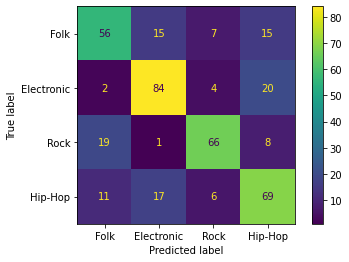

In [16]:
display_test_results(train_and_test(
    'Random Forest',
    BASE_MODELS['Random Forest'],
    X_train, X_test,
    y_train, y_test
))

Accuracy = 0.7925
Precision = 0.7938641657753358
Recall = 0.7925
F1 = 0.7912422442838113
Confusion matrix:


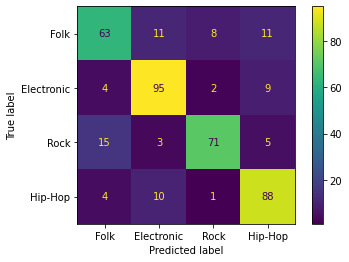

In [17]:
display_test_results(train_and_test(
    'Random Forest',
    IMP_MODELS['Random Forest'],
    IMP_SETS['Random Forest'][X_TRAIN],
    IMP_SETS['Random Forest'][X_TEST],
    IMP_SETS['Random Forest'][Y_TRAIN],
    IMP_SETS['Random Forest'][Y_TEST]
))

/home/teo/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[20:40:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 0.665
Precision = 0.6746913760194343
Recall = 0.665
F1 = 0.667005013149244
Confusion matrix:


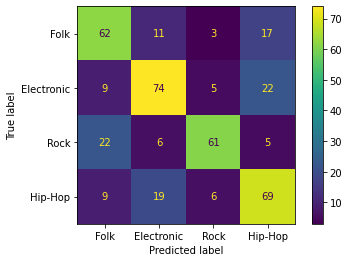

In [18]:
display_test_results(train_and_test(
    'XGBoost',
    BASE_MODELS['XGBoost'],
    X_train, X_test,
    y_train, y_test
))

/home/teo/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[20:40:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 0.815
Precision = 0.8158715272984935
Recall = 0.815
F1 = 0.8150106514019209
Confusion matrix:


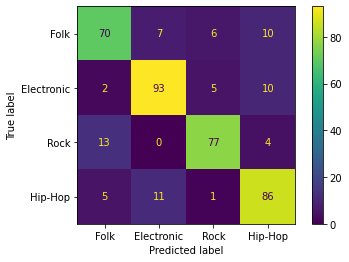

In [19]:
display_test_results(train_and_test(
    'XGBoost',
    IMP_MODELS['XGBoost'],
    IMP_SETS['XGBoost'][X_TRAIN],
    IMP_SETS['XGBoost'][X_TEST],
    IMP_SETS['XGBoost'][Y_TRAIN],
    IMP_SETS['XGBoost'][Y_TEST]
))

Accuracy = 0.28
Precision = 0.19459322225036008
Recall = 0.28
F1 = 0.22599218778653948
Confusion matrix:
/home/teo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


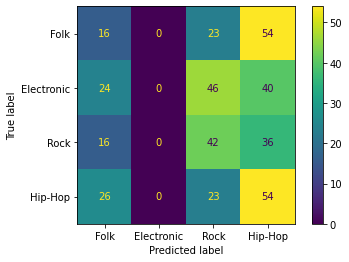

In [20]:
display_test_results(train_and_test(
    'SVC',
    BASE_MODELS['SVC'],
    X_train, X_test,
    y_train, y_test
))

Accuracy = 0.8175
Precision = 0.8179570237005391
Recall = 0.8175
F1 = 0.8171649130828383
Confusion matrix:


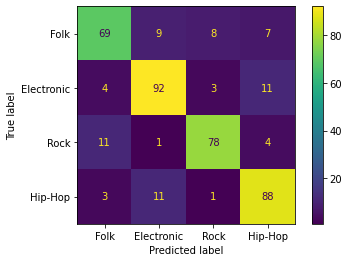

In [21]:
display_test_results(train_and_test(
    'SVC',
    IMP_MODELS['SVC'],
    IMP_SETS['SVC'][X_TRAIN],
    IMP_SETS['SVC'][X_TEST],
    IMP_SETS['SVC'][Y_TRAIN],
    IMP_SETS['SVC'][Y_TEST]
))

Accuracy = 0.545
Precision = 0.5851182966283989
Recall = 0.545
F1 = 0.5184391740477149
Confusion matrix:


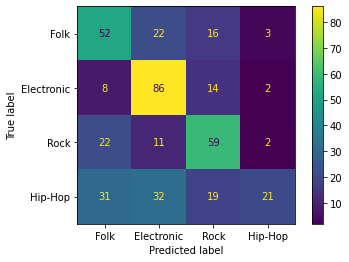

In [22]:
display_test_results(train_and_test(
    'Naive Bayes',
    BASE_MODELS['Naive Bayes'],
    X_train, X_test,
    y_train, y_test
))

Accuracy = 0.6525
Precision = 0.67480842560388
Recall = 0.6525
F1 = 0.6130197907149137
Confusion matrix:


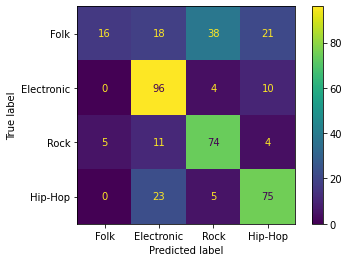

In [23]:
display_test_results(train_and_test(
    'Naive Bayes',
    IMP_MODELS['Naive Bayes'],
    IMP_SETS['Naive Bayes'][X_TRAIN],
    IMP_SETS['Naive Bayes'][X_TEST],
    IMP_SETS['Naive Bayes'][Y_TRAIN],
    IMP_SETS['Naive Bayes'][Y_TEST]
))

In [24]:
display_test_results(train_and_test(
    'KMeans',
    BASE_MODELS['KMeans'],
    X_train, X_test,
    y_train, y_test
))

RandIndex = 0.6166917293233083
NMI = 0.04359842060393945


In [25]:
display_test_results(train_and_test(
    'KMeans',
    IMP_MODELS['KMeans'],
    IMP_SETS['KMeans'][X_TRAIN],
    IMP_SETS['KMeans'][X_TEST],
    IMP_SETS['KMeans'][Y_TRAIN],
    IMP_SETS['KMeans'][Y_TEST]
))

RandIndex = 0.7564786967418546
NMI = 0.34851912386523276


### 4.2. Metode de îmbunătățire și evaluare comparativă [4pct]

Pentru fiecare algoritm, explorați metode prin care să îmbunătățiți performanțele de la pasul precedent (cel de realizarea a baseline-ului).

**Îmbunătățire algoritmi** [2 pct]

Aveți în vedere următoarea listă de idei (și nu numai):
* adăugarea de mai multe feature-uri (momentan la baseline s-au folosit doar *audio_features*)
* [preprocesarea datelor](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) (eng. data preprocessing)
* [selectarea atributelor](https://scikit-learn.org/stable/modules/feature_selection.html) (eng. feature selection)
* modificarea hiperparametrilor fiecărui algoritm (e.g. tipul de kernel la SVM, coeficienți de regularizare, numărul de arbori în RandomForest, adâncimea arborilor în RandomForest)
    * **Atenție!**, exemplu de **AȘA NU**: rularea cu un număr maxim de 10 iterații la baseline și 100 de iterații la modelul mai bun.

În *fma_song_info.zip* există și un fișier *features.csv* -- detalii despre acesta se găsesc în repository-ul menționat în secțiunea [Set de date](#scrollTo=67UlrcAdqj3N).

**Evaluare îmbunătățiri** [2 pct]

* Evaluați variantele îmbunătățite ale algoritmilor, folosind 5-fold [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/). Folosiți aceleași metrici ca în cazul baseline-ului.  **Atenție!** Pentru cross-validation trebuie să vă refaceti împartirea in train/test a setului de date.
* Realizați grafice în care să arătați analiza intra-algoritm a performanței îmbunătățirii (e.g. folosiți un bar chart pentru a compara accuracy-ul variantei baseline a RandomForest cu cea a variantei îmbunătățite).
* Realizați grafice în care să arătați analiza inter-algoritm a performanțelor. Faceți câte un grafic per metrică (e.g. accuracy, precision, recall) în care să încludeți valorile obținute de fiecare algoritm îmbunătățit în parte. 
* Redactați, pe seama graficelor, o analiză a acestora, evidențiind avantajele și dezavantajele fiecărui algoritm implementat.

## 5. Mențiuni

**Pentru rezolvarea task-urilor puteți folosi orice bibliotecă doriți.**

În scheletul temei, datele sunt încărcate folosind biblioteca [pandas](https://pandas.pydata.org/), însă puteți utiliza orice bibliotecă doriți.

**Algoritmii nu trebuie implementați de mână.**

"Rezolvarea" unei probleme de învățare automată se reduce la îmbunătățirea unei metrici.

Un prim pas important este reprezentat de crearea unui *baseline* sau a unei soluții banale, de start (eng. *vanilla solution*) și măsurarea acesteia.

Următorul pas îl reprezintă o serie de modificări aduse feature setului sau algoritmului de învățăre. Aceast pas reprezintă o iterație peste soluția inițială.

Tot procesul constă în aplicarea mai multor *iterații* până se ajunge la o valoare a metricii suficient de bună pentru problema de rezolvat. În cazul nostru, această valoare este reprezentată de ambiția fiecăruia dintre voi :)

**Recomandări**:
* biblioteca [sklearn](https://scikit-learn.org/) - oferă o colecție algoritmi de învățare automată, metrici, metode de selectare de caractaristici, etc.
* pentru XGBoost puteți folosit biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/)

## 6. Sample test
Biblioteca [librosa](https://librosa.github.io/librosa/) permite analizarea și redarea sunetelor.

Se poate folosi pentru a observa dacă anumite melodii găsite într-un anumit gen muzical sunt asemănătoare.

## 7. Link-uri utile
* [Evaluarea algoritmilor de clusterizare](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)
* [Standardizare vs Normalizare](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)

## Bibliografie
<a name="fma">[1] *Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, FMA: A Dataset For Music Analysis, 18th International Society for Music Information Retrieval Conference, 2017*</a>

